In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.set_default_device(device)
torch.cuda.empty_cache()

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E' # /groups/francescavitali/eb2/subImages_slide299/H&E

SPLIT = [55767, 6971, 6971]

tensor_transform = transforms.ToTensor()

dataset = ImageFolderWithPaths(PATH, transform = tensor_transform)

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                           SPLIT,# 80%, 10%, 10%
                                                           generator=torch.Generator(device=device))

test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
model = AE_CNN().to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state

# setting the encoder
encoder = model.encoder

In [6]:
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 26, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=28314, out_features=28314, bias=True)
)

In [7]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self._feed_forward = torch.nn.Sequential(
            torch.nn.Linear(28314, 16384),
            torch.nn.ReLU(),
            torch.nn.Linear(16384, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )
        self._sigmoid = torch.nn.Sigmoid()

        
    
    def forward(self,  x):
        output = self._feed_forward(flattened)
        return self._sigmoid(output)

In [8]:
nn = NeuralNet().to(device)
nn.load_state_dict(torch.load('./ClassifierModels/class_model_gs.pth'))

<All keys matched successfully>

In [9]:
ans = []
correct1_arr = []
total_samples = 0
total_correct = 0
nn.to(device)
nn.eval()
for (image, label, fname) in test_loader:
    nn.eval()
    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        # feeding through nn
        encoded = encoder(image)
        not_rounded = nn._feed_forward(encoded)
        outputs = nn._sigmoid(not_rounded)
        
        # results based on sigmoid
        if outputs < 0.5: 
            outputs = 0
        else:
            outputs = 1
            
        # for visual reference between correct guess of 1
        if outputs == label and outputs == 1:
            correct1_arr.append((image, fname))
            
        # for calculating percentage and visualizing
        total_correct += (outputs == label).item()
        ans.append((label.item(), outputs))

        
print(f'Accuracy: {total_correct/len(test_loader)*100:.2f}%')

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


Accuracy: 61.24%


In [10]:
len(correct1_arr)

159

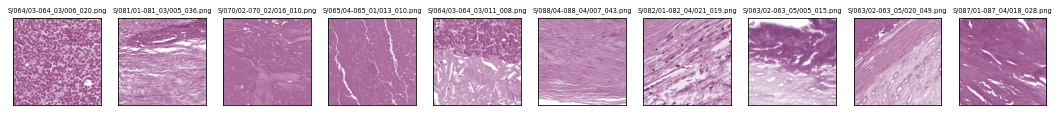

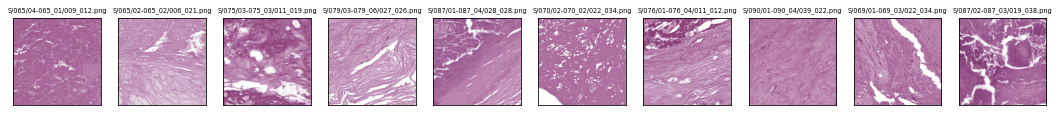

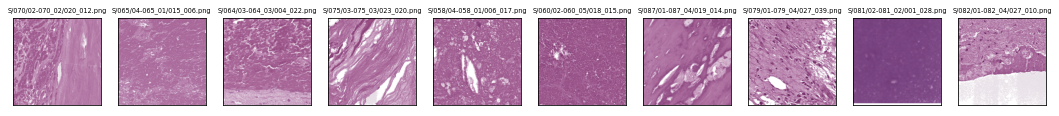

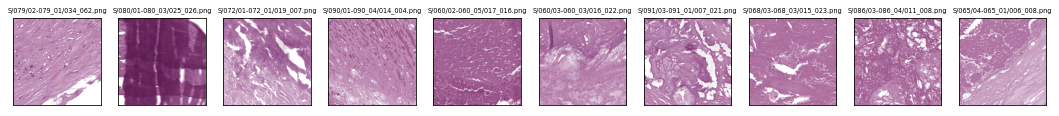

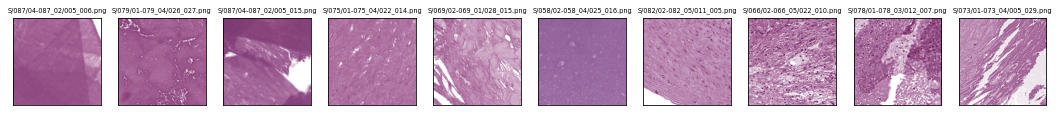

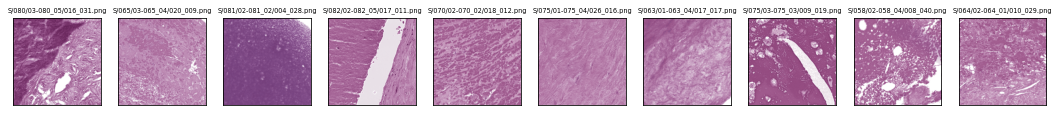

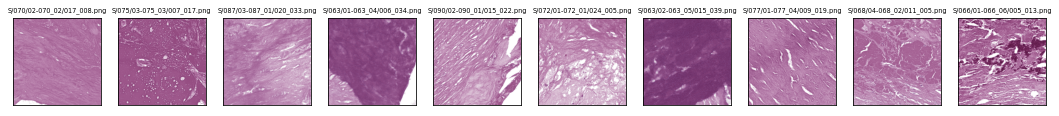

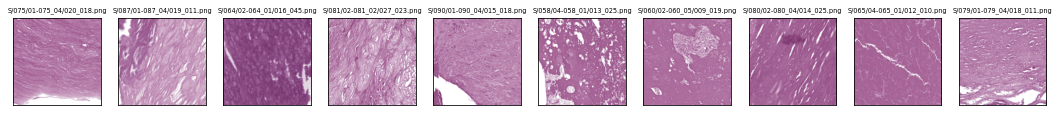

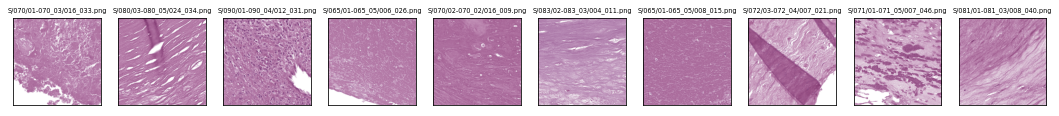

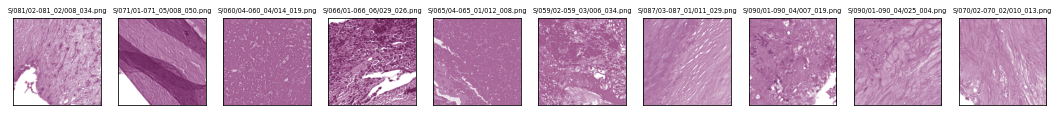

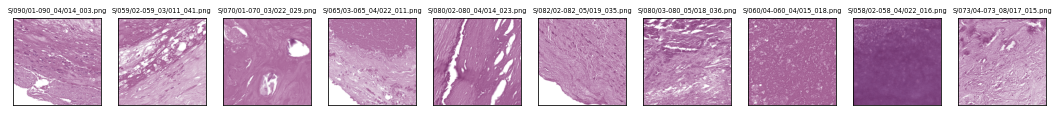

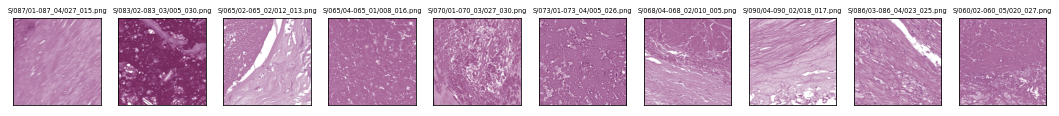

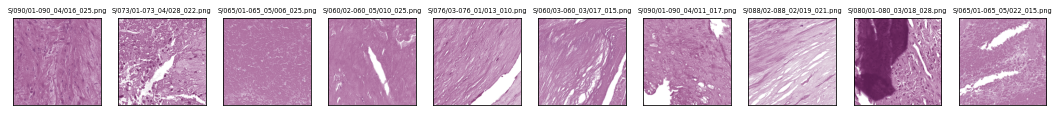

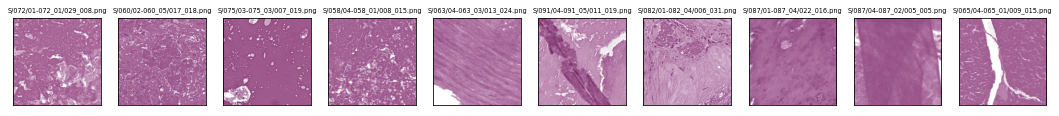

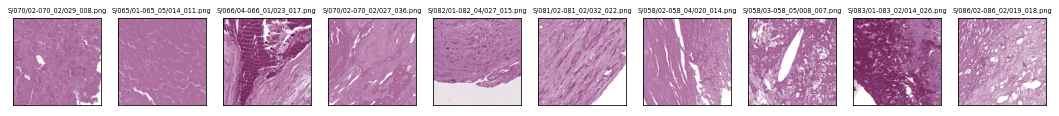

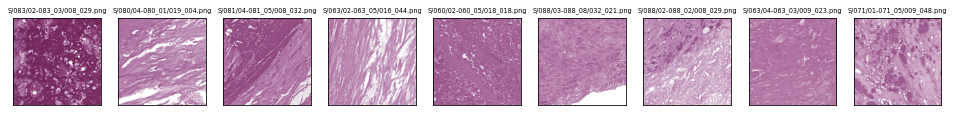

In [11]:
import matplotlib.pyplot as plt

amt = len(correct1_arr)
cols = 10
rows = amt // cols + 1

for k in range(rows):
    plt.figure(figsize=(299, 299))
    for i in range(cols):
        try:
            ax = plt.subplot(cols, amt, i+1)
            img = correct1_arr[i+k*cols][0].squeeze()
            img = img.detach().cpu().numpy()
            plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
            ax.set_title("/".join(correct1_arr[i+k*cols][1][0].split('/')[-4:]),fontsize=6.5)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        except IndexError:
            ax.remove()
            break